# Q Learning in Stochastic Enviornment

The Bellman's equation utilizes the Markov Decision Process in a Stochastic enviornment to get

$$
\mathcal Q_{t+1}(s,a) = \mathcal Q_t(s,a) + \alpha\cdot\left(\mathbb E[\mathscr R(s,a)] - \mathcal Q_t(s,a) + \gamma\sum_{s'}\mathcal P_{s,a}(s')\max_{a'}\mathcal Q_t(s',a')\right)
$$
where 
$$
E[\mathscr R(s,a)] = \sum_{s'}\mathcal P_{s,a}(s')\mathscr R_{s'}
$$
Notice that $\mathscr R_{s'}$ does not depend on from where the bot came from because in this simulated enviornment, that information is slightly irrelevant.

## Enviornment
We use the idea of enviornment from  **Frozen Lake** by OpenAI gym.

| S | F | F | F |
| -- | -- | -- | -- |
| F | H | F | H |
| F | F | F | H |
| H | F | F | G |

In [400]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [401]:
# Actions in the enviornment
class Actions:
    def __init__(self, stochastic, rewards, env, states):
        self.stochastic = stochastic
        self.rewards = rewards
        self.env = env
        self.states = states

    def up(s):
        return (s[0]-1,s[1])
    def down(s):
        return (s[0]+1,s[1])
    def left(s):
        return (s[0],s[1]-1)
    def right(s):
        return (s[0],s[1]+1)
    
    actions = [up, down, left, right]

    def move(self, s, idx):
        return Actions.actions[np.random.choice(4, p=self.stochastic[idx])](s)

    def getRewards(self, s, idx):
        reward = 0
        for i in range(4):
            if self.stochastic[idx][i] == 0:
                continue
            next_state = Actions.actions[i](s)
            r_s = 0
            if self.states.inBounds(next_state):
                r_s = self.rewards[self.env[next_state[0]][next_state[1]]]
            else:
                r_s = -1
            reward += self.stochastic[idx][i]*r_s
        return reward

In [402]:
# States in the enviornment
class States:
    def __init__(self, w, h):
        self.w = w
        self.h = h
        self.goal = (w - 1, h - 1)

    def getStates(self):
        states = []
        for i in range(self.w):
            for j in range(self.h):
                states.append((i,j))
        return states
    
    def inBounds(self,s):
        if min(s) < 0 or s[0] >= self.w or s[1] >= self.h:
            return False
        else:
            return True

In [403]:
class Q_Agent:
    def __init__(self, env, actions: Actions, states_class: States, discount=0.95, lr=0.3, start=(0,0), eps_decay = 0.99, eps_min = 0.1):
        self.env = env
        self.actions = actions
        self.states_class = states_class
        self.states = self.states_class.getStates()
        self.start = start
        self.end = self.states_class.goal
        self.eps_min = eps_min
        self.eps_decay = eps_decay

        self.discount = discount
        self.lr = lr

        self.q = {}
        for state in self.states:
            self.q[state] = [-1]*4

    def train(self, episodes = 1000):
        rewards_collected = []
        eps = 1
        for episode in range(episodes):
            reward = 0
            cur = (0,0)
            next = None
            max_steps = 10000
            step_num = 0
            while cur != self.end and step_num < max_steps:
                step_num+=1
                action = 0
                if np.random.rand() < eps:
                    action = np.random.randint(0,4)
                else:
                    action = self.q[cur].index(max(self.q[cur]))
                next = self.actions.move(cur, action)
                if not self.states_class.inBounds(next):
                    continue
                markov_sum = 0
                for i in range(4):
                    prob = self.actions.stochastic[action][i]
                    if prob == 0:
                        continue
                    pos_next = self.actions.actions[i](cur)
                    if self.states_class.inBounds(pos_next):
                        val = max(self.q[pos_next])
                    else:
                        val = -1
                    markov_sum += prob * val
                temporal_diff = self.actions.getRewards(cur,action) - self.q[cur][action] + self.discount * markov_sum
                self.q[cur][action] += self.lr * temporal_diff
                reward += self.actions.rewards[self.env[next[0]][next[1]]]
                cur = next
            rewards_collected.append(reward)
            if episode % 70 == 0:
                print(f"Episode {episode}, rewards collected : {reward}")
            eps = max(self.eps_min, self.eps_decay*eps)
        return rewards_collected
    
    def solve(self):
        cur = self.start
        route = [cur]
        
        while cur != self.end:
            cur = self.actions.move(cur, self.q[cur].index(max(self.q[cur])))
            route.append(cur)


        return route     

In [404]:
# enviornment
# env = [
#     "SFFF",
#     "FFFH",
#     "FFFH",
#     "HFFG",
# ]
env = [
    "SFFFFFFFH",
    "FFHHHHHFH",
    "FFHFFFFFH",
    "FFHFFHFFH",
    "FFHFFHFFH",
    "FFFFFHFFG",
]


# Deterministic and Stochastic behavior
deterministic = [
    [1, 0, 0, 0], # up
    [0, 1, 0, 0], # down
    [0, 0, 1, 0], # left
    [0, 0, 0, 1] # right
]

stochastic = [
    [1, 0, 0, 0], # up
    [0, 0.9, 0, 0.1], # down
    [0, 0, 1, 0], # left
    [0, 0, 0, 1] # right
]

# Reward Policy
rewards = {
    "S": -0.04,
    "F": -0.04,
    "H": -10,
    "G": 1
}



| S | F | F | F |
| -- | -- | -- | -- |
| F | H | F | H |
| F | F | F | H |
| H | F | F | G |

| S | F | F | F | F | F | F | F | H |
| -- | -- | -- | -- | -- | -- | -- | -- | -- |
| F | F | H | H | H | H | H | F | H |
| F | F | H | F | F | F | F | F | H |
| F | F | H | F | F | H | F | F | H |
| F | F | H | F | F | H | F | F | H |
| F | F | F | F | F | H | F | F | G |


| 0 0 | 0 1 | 0 2 | 0 3 |
| -- | -- | -- | -- |
| 1 0 | 1 1 | 1 2 | (1 3) |
| 2 0 | 2 1 | 2 2 | (2 3) |
| (3 0) | 3 1 | 3 2 | 3 3 |

Episode 0, rewards collected : -1724.1599999999903
Episode 70, rewards collected : -40.11999999999999
Episode 140, rewards collected : -445.7200000000007
Episode 210, rewards collected : -221.8000000000001
Episode 280, rewards collected : -91.92000000000012
Episode 350, rewards collected : -49.999999999999986
Episode 420, rewards collected : -161.63999999999993
Episode 490, rewards collected : -40.67999999999998
Episode 560, rewards collected : -19.87999999999999
Episode 630, rewards collected : -90.08000000000003
Episode 700, rewards collected : -29.839999999999986
Episode 770, rewards collected : -19.479999999999993
Episode 840, rewards collected : -39.79999999999998
Episode 910, rewards collected : -19.719999999999985
Episode 980, rewards collected : -29.839999999999982
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (5, 8)]
0.52
9


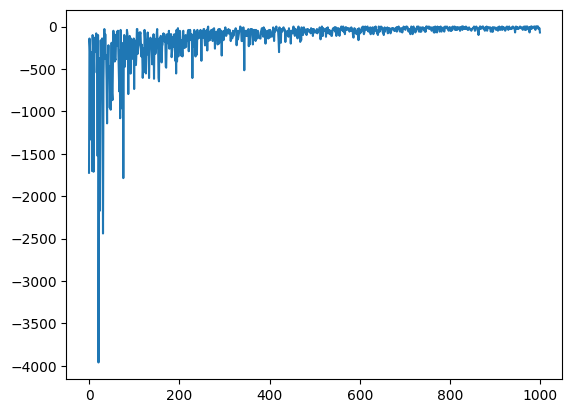

In [405]:
states_1 = States(len(env), len(env[0]))
action_1 = Actions(stochastic=deterministic, rewards=rewards, env=env, states=states_1)
model_1 = Q_Agent(env=env,actions=action_1,states_class=states_1,eps_decay=0.999,start=(0,0))
x = model_1.train()
print(model_1.solve())
plt.plot(x)
print(max(x))
print(x.count(max(x)))

In [406]:
for i in model_1.q:
    l = []
    for k in model_1.q[i]:
        l.append(int(k*100))
    print(f"{i} : {l}")

(0, 0) : [-100, -38, -100, -34]
(0, 1) : [-100, -36, -36, -31]
(0, 2) : [-100, -1030, -34, -29]
(0, 3) : [-100, -1022, -31, -26]
(0, 4) : [-100, -1019, -29, -23]
(0, 5) : [-100, -1016, -26, -20]
(0, 6) : [-100, -1013, -23, -17]
(0, 7) : [-100, -14, -20, -1016]
(0, 8) : [-100, -1013, -17, -100]
(1, 0) : [-36, -40, -100, -36]
(1, 1) : [-34, -38, -38, -1030]
(1, 2) : [-31, -1022, -36, -1022]
(1, 3) : [-29, -23, -1030, -1019]
(1, 4) : [-26, -20, -1022, -1016]
(1, 5) : [-23, -17, -1019, -1013]
(1, 6) : [-20, -14, -1016, -14]
(1, 7) : [-17, -10, -1013, -1013]
(1, 8) : [-1016, -1010, -14, -100]
(2, 0) : [-38, -42, -100, -38]
(2, 1) : [-36, -40, -40, -1022]
(2, 2) : [-1030, -1025, -38, -23]
(2, 3) : [-1022, -26, -1022, -20]
(2, 4) : [-1019, -23, -23, -17]
(2, 5) : [-1016, -1010, -20, -14]
(2, 6) : [-1013, -10, -17, -10]
(2, 7) : [-14, -7, -14, -1010]
(2, 8) : [-1013, -1006, -10, -100]
(3, 0) : [-40, -40, -100, -40]
(3, 1) : [-38, -38, -42, -1025]
(3, 2) : [-1022, -1027, -40, -26]
(3, 3) : [-23

Episode 0, rewards collected : -1298.319999999996
Episode 70, rewards collected : -321.9600000000003
Episode 140, rewards collected : -446.04000000000127
Episode 210, rewards collected : -904.3999999999971
Episode 280, rewards collected : -321.3200000000001
Episode 350, rewards collected : -110.32000000000006
Episode 420, rewards collected : -317.9999999999997
Episode 490, rewards collected : -40.67999999999998
Episode 560, rewards collected : -30.719999999999978
Episode 630, rewards collected : -30.07999999999998
Episode 700, rewards collected : -72.56000000000017
Episode 770, rewards collected : -40.27999999999999
Episode 840, rewards collected : -0.04000000000000026
Episode 910, rewards collected : -40.599999999999966
Episode 980, rewards collected : -0.6000000000000008
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (5, 2), (5, 3), (4, 3), (3, 3), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (5, 7), (5, 8)]
0.19999999999999984
1


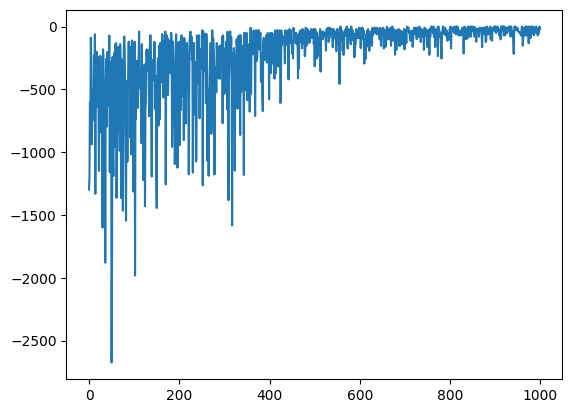

In [407]:
states_2 = States(len(env), len(env[0]))
action_2 = Actions(stochastic=stochastic, rewards=rewards, env=env, states=states_2)
model_2 = Q_Agent(env=env,actions=action_2,states_class=states_2, eps_decay=0.999, lr=0.1,start=(0,0))
x = model_2.train()
print(model_2.solve())
plt.plot(x)
print(max(x))
print(x.count(max(x)))

| 0 0 | 0 1 | 0 2 | 0 3 | 0 4 | 0 5 | 0 6 | 0 7 | (0 8) |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| 1 0 | 1 1 | (1 2) | (1 3) | (1 4) | (1 5) | (1 6) | 1 7 | (1 8) |
| 2 0 | 2 1 | (2 2) | 2 3 | 2 4 | 2 5 | 2 6 | 2 7 | (2 8) |
| 3 0 | 3 1 | (3 2) | 3 3 | 3 4 | (3 5) | 3 6 | 3 7 | (3 8) |
| 4 0 | 4 1 | (4 2) | 4 3 | 4 4 | (4 5) | 4 6 | 4 7 | (4 8) |
| 5 0 | 5 1 | 5 2 | 5 3 | 5 4 | (5 5) | 5 6 | 5 7 | 5 8 |


In [408]:
for i in model_2.q:
    l = []
    for k in model_2.q[i]:
        l.append(int(k*100))
    print(f"{i} : {l}")

(0, 0) : [-100, -49, -100, -52]
(0, 1) : [-100, -50, -50, -53]
(0, 2) : [-100, -948, -52, -54]
(0, 3) : [-100, -952, -53, -56]
(0, 4) : [-100, -953, -54, -57]
(0, 5) : [-100, -954, -56, -58]
(0, 6) : [-100, -924, -57, -59]
(0, 7) : [-100, -163, -58, -1063]
(0, 8) : [-100, -985, -61, -100]
(1, 0) : [-50, -47, -100, -50]
(1, 1) : [-52, -148, -48, -1047]
(1, 2) : [-53, -1026, -50, -1052]
(1, 3) : [-54, -128, -1047, -1053]
(1, 4) : [-56, -125, -1052, -1054]
(1, 5) : [-57, -119, -1053, -1019]
(1, 6) : [-60, -20, -1055, -63]
(1, 7) : [-59, -124, -1020, -1071]
(1, 8) : [-1071, -936, -64, -100]
(2, 0) : [-48, -44, -100, -48]
(2, 1) : [-50, -144, -46, -1024]
(2, 2) : [-1047, -926, -48, -25]
(2, 3) : [-1052, -27, -1024, -22]
(2, 4) : [-1053, -24, -25, -19]
(2, 5) : [-1054, -912, -22, -16]
(2, 6) : [-1019, -12, -19, -19]
(2, 7) : [-61, -115, -16, -1018]
(2, 8) : [-1070, -933, -19, -100]
(3, 0) : [-46, -42, -100, -46]
(3, 1) : [-48, -142, -44, -1026]
(3, 2) : [-1024, -929, -46, -28]
(3, 3) : [-25,

## Observations

We notice that in a determinsitic world, the bot